In [1]:
%matplotlib inline

from visualiser2 import *

from ipywidgets import widgets
from IPython.display import display
from IPython.display import clear_output

In [2]:
dropdown = widgets.Dropdown(options=list(all_bots),description='Bot')
slider = widgets.IntSlider(min(steps[dropdown.value]),min=min(steps[dropdown.value]),max=max(steps[dropdown.value]),description='Step',width='100%',continuous_update=False)
button_next = widgets.Button(description = "Next")
button_prev = widgets.Button(description = "Prev")
q_arrows = widgets.Text(description = "Arrows",value='frontierDir')
q_heat = widgets.Text(description = "HeatMap",value='production')
q_size = widgets.Text(description = "Size",value='strength')
q_color = widgets.Text(description = "Color",value='owner')

def get_state():
    return {
        'color':q_color.value if q_color.value else None,
        'heat':q_heat.value if q_heat.value else None,
        'size':q_size.value if q_size.value else None,
        'arrows':q_arrows.value if q_arrows.value else None
    }

def push_next(_):
    current = slider.value
    new = str(int(current)+1)
    slider.value = new
    
def push_prev(_):
    current = slider.value
    new = str(int(current)-1)
    slider.value = new

def observe_slider(change):
    step = change['new']
    state = get_state()
    res = 16
    
    figure = plt.figure(figsize=(8,8))
    
    cache_key = (step,) + tuple(state.values())
    
    if cache_key in im_cache:
        cached_ims = im_cache[cache_key]
        plot_ims(cached_ims=cached_ims)
    else:
        with open('dumps/{}'.format(get_gamemap(step,dropdown.value)),'rb') as f:
            data = pickle.load(f)
        ims = plot_ims(data,state)
        im_cache[cache_key] = ims
        
    clear_output()
    

slider.observe(observe_slider,names='value')

button_next.on_click(push_next)
button_prev.on_click(push_prev)



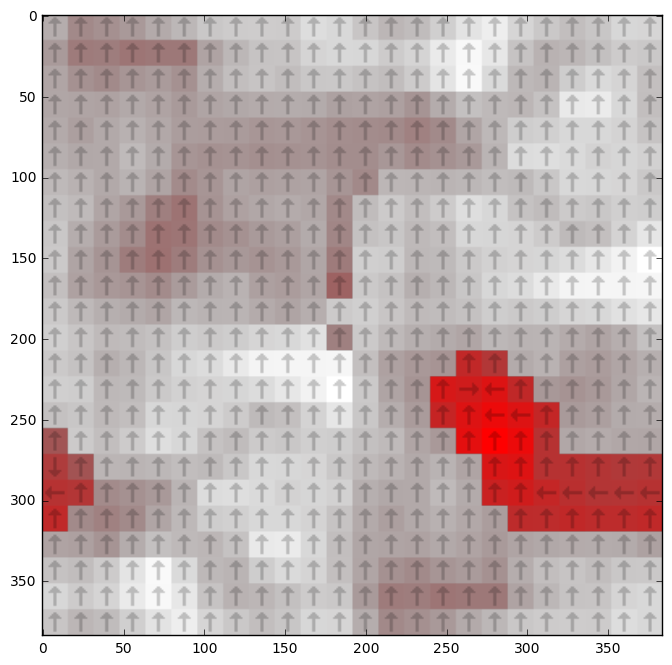

In [3]:
display(dropdown)
display(widgets.HBox([q_color,q_heat]))
display(widgets.HBox([q_size,q_arrows]))
display(slider)
display(widgets.HBox([button_prev,button_next]))

In [4]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [40]:
del im_cache
im_cache = {}

In [106]:
with open('dumps/{}'.format(get_gamemap(50,'refactored')),'rb') as f:
    data = pickle.load(f)
gamemap = data['gamemap']

In [96]:
def shouldMove(square,new_square,map_uptodate,my_id):
    if square.strength <= 3*square.production: 
    #if strength <= 5*production
        return False
    if map_uptodate[new_square].strength > square.strength and map_uptodate[new_square].owner != my_id: 
    #if foreign tile of superior strength
        return False
    if map_uptodate[new_square].strength > square.strength and map_uptodate[new_square].strength + square.strength > 255 and map_uptodate[new_square].owner == my_id:
    #if friendly tile and sum>255
        return False
    return True

def map_directions(my_id,attr_map,gamemap,momentum_map,directions_dict=None):
    directions_map = {}
    wanted_directions_map = {}
    moves_list = []
    map_uptodate = {square:Square(
        square.x, 
        square.y, 
        square.owner, 
        square.strength if square.owner!=my_id else 0., 
        square.production) for square in gamemap}
    for square in gamemap:
        if square.owner!=my_id:
            directions_map[square] = None
            wanted_directions_map[square] = None
            continue
        if directions_dict is None or directions_dict.get(square) is None:
            # candidate_directions = [(d,n) for d,n in enumerate(gamemap.neighbors(square)) if d != opp_cardinal[momentum_map[(square.x,square.y)]]]
            candidate_directions = [(d,n) for d,n in enumerate(gamemap.neighbors(square))]
            potential_direction,new_square = max(candidate_directions,key=lambda dsq:attr_map[dsq[1]])
        else:
            potential_direction = directions_dict.get(square,STILL)
            new_square = gamemap.get_target(square,potential_direction)
        wanted_directions_map[square] = potential_direction
        if shouldMove(square,new_square,map_uptodate,my_id):
            directions_map[square] = potential_direction
            new_strength = square.strength + map_uptodate[new_square].strength if map_uptodate[new_square].owner==my_id else square.strength-map_uptodate[new_square].strength
            #updating mapping
            map_uptodate[new_square]._replace(strength=new_strength)
            map_uptodate[new_square]._replace(owner = my_id)
            map_uptodate[square]._replace(strength = 0)
        else:
            directions_map[square] = STILL

        moves_list.append((square,directions_map[square]))
    return moves_list,directions_map,wanted_directions_map

In [97]:
final_attr_map = data['final_attr_map']
momentum_map = data['momentum_map']
my_id = data['my_id']

In [98]:
moves_list,directions_map,wanted_directions_map = map_directions(my_id,final_attr_map,gamemap,momentum_map)

In [99]:
data2 = {k:v for k,v in data.items()}

In [100]:
data2['directions_map'] = directions_map
data2['wanted_directions_map'] = wanted_directions_map

In [101]:
[wanted_directions_map[sq] for sq in data['inner']]

[2, 2, 2, 2, 2, 2, 1, 2, 3, 2]

In [102]:
[data['wanted_directions_map'][sq] for sq in data['inner']]

[3, 2, 1, 2, 2, 2, 1, 2, 0, 2]

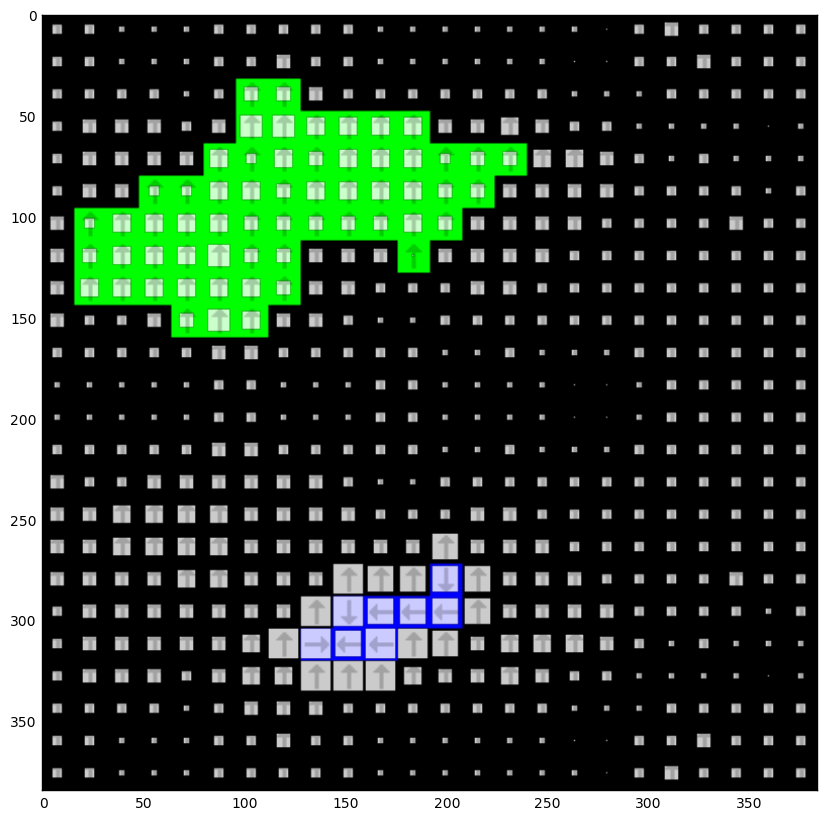

In [107]:
state = {
    'color':'owner',
    'size':'final_attr_map',
    'arrows':'wanted_directions_map'
}

plt.figure(figsize=(10,10))
_ = plot_ims(data,state)

In [74]:
[data['wanted_directions_map'][square] for square in data['inner']]

[3, 3, 3, 3, 0, 2, 0, 3, 0, 0, 1, 3, 3, 3, 3]

In [75]:
[data['directions_map'][square] for square in data['inner']]

[3, 4, 3, 3, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 3]

In [108]:
data['target_reached']

False

In [35]:
data['inner']

{Square(x=0, y=3, owner=2, strength=106, production=7),
 Square(x=17, y=0, owner=2, strength=32, production=8),
 Square(x=18, y=0, owner=2, strength=33, production=11),
 Square(x=19, y=0, owner=2, strength=22, production=11),
 Square(x=19, y=1, owner=2, strength=9, production=9),
 Square(x=20, y=1, owner=2, strength=0, production=8),
 Square(x=20, y=2, owner=2, strength=220, production=8),
 Square(x=21, y=2, owner=2, strength=12, production=4),
 Square(x=22, y=2, owner=2, strength=4, production=2),
 Square(x=23, y=2, owner=2, strength=3, production=3),
 Square(x=23, y=3, owner=2, strength=0, production=4)}

In [34]:
data['frontier']

{Square(x=0, y=2, owner=0, strength=17, production=5),
 Square(x=0, y=4, owner=0, strength=54, production=9),
 Square(x=1, y=3, owner=0, strength=42, production=6),
 Square(x=16, y=0, owner=0, strength=142, production=7),
 Square(x=17, y=1, owner=0, strength=141, production=5),
 Square(x=17, y=23, owner=0, strength=133, production=12),
 Square(x=18, y=1, owner=0, strength=75, production=8),
 Square(x=18, y=23, owner=0, strength=84, production=14),
 Square(x=19, y=2, owner=0, strength=44, production=7),
 Square(x=19, y=23, owner=0, strength=66, production=15),
 Square(x=20, y=0, owner=0, strength=60, production=9),
 Square(x=20, y=3, owner=0, strength=42, production=9),
 Square(x=21, y=1, owner=0, strength=30, production=4),
 Square(x=21, y=3, owner=0, strength=28, production=5),
 Square(x=22, y=1, owner=0, strength=20, production=3),
 Square(x=22, y=3, owner=0, strength=13, production=3),
 Square(x=23, y=1, owner=0, strength=20, production=3),
 Square(x=23, y=4, owner=0, strength=31, p

In [19]:
min([x for x in data['final_attr_map'].values() if x is not None])

0.0

In [8]:
[x for x in data['final_attr_map'].values() if x is None]

[]

In [23]:
data['my_id']

2

In [37]:
[data['final_attr_map'][square] for square in gamemap if square.owner == data['my_id']]

[1.2724211305929285,
 1.3224211305929285,
 1.3724211305929286,
 1.3224211305929285,
 1.2724211305929285,
 1.2946398111704476,
 1.2446398111704475,
 1.1946398111704475,
 1.22605540148615,
 1.22605540148615,
 1.2100971045842295]

In [38]:
[data['final_attr_map'][square] for square in data['frontier']]

[1.2488009637443245,
 1.2306374977120673,
 1.2600971045842295,
 1.1936844944506402,
 1.3446398111704476,
 1.1671605195950367,
 0.6950169907295578,
 1.2433373044815346,
 1.2128891901124665,
 1.090310158829033,
 1.2288708404534066,
 0.6950040588127497,
 1.264894414327185,
 0.9051401019075248,
 1.4224211305929286,
 1.167664588822404,
 1.27605540148615,
 1.16639857507698]

In [39]:
[data['final_attr_map'][square] for square in data['inner']]

[1.3224211305929285,
 1.1946398111704475,
 1.2946398111704476,
 1.2724211305929285,
 1.2724211305929285,
 1.2446398111704475,
 1.22605540148615,
 1.2100971045842295,
 1.3724211305929286,
 1.22605540148615,
 1.3224211305929285]

In [20]:
data['final_attr_map'].values()

dict_values([0.4220860886851393, 0.6389812974157167, 0.31595855815651747, 0.057814211529879506, 0.14972463385938575, 0.3680702056878575, 0.685626191731916, 0.7068846606353201, 0.39762262160736733, 0.2711291533125076, 0.4262343299931032, 0.6935600835733703, 0.2002134975049698, 0.8008539900198792, 0.7586742869893301, 0.3680702056878575, 0.6112849405655401, 0.7980065114203417, 0.24524575033469911, 0.4220860886851394, 0.8296076919956185, 0.389630410970019, 0.19455403870339563, 0.8677456489107063, 0.28117012860562296, 0.9067406385654591, 0.0, 0.3035518682299484, 0.4710155584405047, 0.41385046046492757, 0.48643961215465126, 0.6112849405655402, 0.5939794717838451, 0.5157435392916548, 0.644082924256562, 0.574506065154773, 0.6137774351900684, 0.7339141547324436, 0.5435539981337985, 0.34338107022597275, 0.10041228853097489, 0.5842021988721652, 0.5577330723355918, 0.07943780680757839, 0.5964364680108726, 0.5890806929287192, 0.4262343299931032, 0.40569597143900354, 0.8037065398190597, 0.5553572153

In [9]:
from collections import namedtuple

In [10]:
Test = namedtuple('Test','a b c')

In [11]:
Test.__hash__ = lambda x:hash((x.a,x.b))
Test.__eq__ = lambda self,other:self.a==other.a and self.b==other.b

In [12]:
t = Test(a=2,b=3,c=8)
t2 = Test(a=2,b=8,c=9)
t3 = Test(a=2,b=3,c=9)

In [13]:
t == t3

True

In [14]:
d = {}

In [15]:
d[t] = 4

In [16]:
d[t3]

4

In [17]:
t2.__hash__()

3713082714456163081